In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"
import findspark
findspark.init()


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler #normalization
from pyspark.ml.clustering import KMeans #clustering
from pyspark.sql.functions import when

spark = SparkSession.builder.getOrCreate()

In [3]:
testing = spark.read.option("inferSchema", "True").csv("Test.csv", header=True)
training = spark.read.option("inferSchema", "True").csv("Train.csv", header=True)

In [6]:
columns = ["Glucose", "DiabetesPedigreeFunction", "Insulin"]

testing = testing.select("Glucose", "DiabetesPedigreeFunction", "Insulin", "Outcome")
training = training.select(columns)

In [9]:
testing = testing.na.drop()
training = training.na.drop()
testing.show()

+-------+------------------------+-------+-------+
|Glucose|DiabetesPedigreeFunction|Insulin|Outcome|
+-------+------------------------+-------+-------+
|    158|                    1.92|     40|    Yes|
|    131|                    1.46|     64|    Yes|
|     79|                    0.62|     30|     No|
|    117|                    0.89|    186|    Yes|
|    124|                    0.77|    158|    Yes|
|    184|                    0.98|     98|    Yes|
|    189|                    1.35|    124|    Yes|
|     82|                    0.55|      3|     No|
|    126|                    1.98|    132|    Yes|
|    177|                     0.8|    145|    Yes|
|    127|                    1.28|     72|    Yes|
|    118|                    1.36|    122|    Yes|
|    119|                    0.35|     55|     No|
|    187|                    1.61|    108|    Yes|
|    155|                     0.8|     68|    Yes|
|    166|                    0.66|    180|    Yes|
|    191|                    1.

In [ ]:
testing = testing.withColumn(
    "Outcome",
      when(testing["Outcome"] == "No",0)
      .otherwise(1)
)

testing.show()

In [ ]:
assembler = VectorAssembler(inputCols = columns, outputCol = 'assembled')
scaler = StandardScaler(inputCol = "assembled", outputCol = "features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

testing.show()

In [13]:
kmeans = KMeans(k=2)
model = kmeans.fit(training)
data = model.transform(testing)
data = data.toPandas()


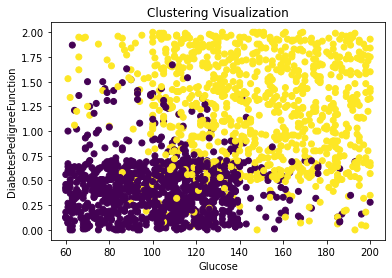

Accuracy:91.01479915433404%


In [23]:
import matplotlib.pyplot as plt

plt.scatter(
    data["Glucose"],
    data["DiabetesPedigreeFunction"],
    c=data["prediction"]
)

plt.title("Clustering Visualization")
plt.xlabel("Glucose")
plt.ylabel("DiabetesPedigreeFunction")
plt.show()


c = 0
for i, row in data.iterrows():
  if row["Outcome"] == row["prediction"]:
    c+=1

acc = c/len(data)*100
print(f'Accuracy:{acc}%')